## Triage Task

### Import pre-trained Word2Vec vector space

In [ ]:
#######################################################

Resolver o problema de ter mais titulos do que abstracts.
Melhorar o grafico.


#######################################################

In [1]:
import gensim
from gensim.models import KeyedVectors

# wv_from_bin = gensim.models.KeyedVectors.load_word2vec_format('wikipedia-pubmed-and-PMC-w2v.bin', binary = True)
wv_from_bin = gensim.models.KeyedVectors.load_word2vec_format('Pubmed-and-PMC-w2v.bin',limit=10000, binary = True)

### Import training set file

In [22]:
import json
import numpy as np

import json 
import pandas as pd 
from pandas.io.json import json_normalize

with open('PMtask_Triage_TrainingSet.json') as json_file:
    data = json.load(json_file)
    
documents = json_normalize(data['documents'])
documents.head()

,id,infons.relevant,passages,relations
0,9685346,no,[{'text': 'The molecular basis of Rieger syndr...,[]
1,10364224,no,[{'text': 'Identification of the cell cycle re...,[]
2,10688642,no,[{'text': 'The Est1 subunit of yeast telomeras...,[]
3,12059041,no,[{'text': 'Mutant and wild-type alpha-synuclei...,[]
4,12897151,no,[{'text': 'Human mitochondrial transcription f...,[]


### Unpack the passages column into a standalone dataframe

In [2]:
passages = json_normalize(data = data['documents'], record_path = 'passages', record_prefix = 'passage.', meta = 'id')
passages.head(3)

,passage.annotations,passage.infons,passage.offset,passage.relations,passage.sentences,passage.text,id
0,[],{'type': 'title'},0,[],[],The molecular basis of Rieger syndrome. Analys...,9685346
1,[],{'type': 'abstract'},90,[],[],Rieger syndrome is an autosomal-dominant devel...,9685346
2,[],{'type': 'title'},0,[],[],Identification of the cell cycle regulator VCP...,10364224


### Unpack the passage.infons column into a standalone dataframe

In [3]:
types = json_normalize(passages['passage.infons'], meta = 'id')
types.head(3)

,type
0,title
1,abstract
2,title


### Merge

In [4]:
documents = documents.merge(passages, on = "id", how = "inner")
documents = documents.merge(types, left_index = True, right_index = True)
documents = documents.drop(columns = ['passages', 'relations', 'passage.annotations', 'passage.infons', 'passage.relations', 'passage.sentences'])
documents['infons.relevant'].replace('no', 0, inplace = True)
documents['infons.relevant'].replace('yes', 1, inplace = True)
documents.name = 'training'
documents.head(10)

,id,infons.relevant,passage.offset,passage.text,type
0,9685346,0,0,The molecular basis of Rieger syndrome. Analys...,title
1,9685346,0,90,Rieger syndrome is an autosomal-dominant devel...,abstract
2,10364224,0,0,Identification of the cell cycle regulator VCP...,title
3,10364224,0,134,The human band 4.1-related protein-tyrosine ph...,abstract
4,10688642,0,0,The Est1 subunit of yeast telomerase binds the...,title
5,10688642,0,68,"Est1 is a component of yeast telomerase, and e...",abstract
6,12059041,0,0,Mutant and wild-type alpha-synuclein interact ...,title
7,12059041,0,87,"Alpha-synuclein, a presynaptic protein, was fo...",abstract
8,12897151,0,0,Human mitochondrial transcription factor B1 in...,title
9,12897151,0,185,A significant advancement in understanding mit...,abstract


In [5]:
def concat_text(dataframe):
    d = {
        'passage.text':[],
        'infons.relevant':[]
    }
    # temp = ''
    title_count = 0
    abst_count = 0
    for index, row in dataframe.iterrows():
    #     if index > 0 and index % 2 == 0:
    #         d['passage.text'].append(temp)
    #         d['infons.relevant'].append(row['infons.relevant'])
    #         temp = ''
    #     temp += row['passage.text']
        if row['type'] == 'title':
            temp = ''
            temp += row['passage.text']
            title_count += 1
        else:
            temp += row['passage.text']
            d['passage.text'].append(temp)
            d['infons.relevant'].append(row['infons.relevant'])
            abst_count += 1

    print(title_count)
    print(abst_count)
    df = pd.DataFrame(data=d)
    return df

In [6]:
new_documents = concat_text(documents)
new_documents.name = 'training'
new_documents.shape

4082
4080


(4080, 2)

In [7]:
size = new_documents.shape[0]

### Import test set file

In [8]:
with open('PMtask_Triage_TestSet.json') as json_file:
    data_test = json.load(json_file)
    
documents_test = json_normalize(data_test['documents'])
passages_test = json_normalize(data = data_test['documents'], record_path = 'passages', record_prefix = 'passage.', meta = 'id')
types_test = json_normalize(passages_test['passage.infons'], meta = 'id')

documents_test = documents_test.merge(passages_test, on = "id", how = "inner")
documents_test = documents_test.merge(types_test, left_index = True, right_index = True)
documents_test = documents_test.drop(columns = ['passages', 'relations', 'passage.annotations', 'passage.infons', 'passage.relations', 'passage.sentences'])
documents_test['infons.relevant'].replace('no', 0, inplace = True)
documents_test['infons.relevant'].replace('yes', 1, inplace = True)
documents_test.name = 'test'
print(documents_test[documents_test['infons.relevant']==1].shape)
print(documents_test.shape)

(1408, 5)
(2854, 5)


In [9]:
new_documents_test = concat_text(documents_test)
new_documents_test.name = 'test'

1427
1427


### Text to word sequence (embedding)

In [10]:
from keras.preprocessing.text import text_to_word_sequence

def vectorize(row, text, embedding_matrix):
    for index, word in enumerate(text):
        try:
            embedding_matrix[row][index] = wv_from_bin.wv.vocab[word].index
        except:
            pass
        
embedding_matrix_train = np.zeros((4080, 3900))
embedding_matrix_test = np.zeros((1427, 3900))

def word_sequence(df):
    df['passage.text'] = df['passage.text'].apply(lambda x: text_to_word_sequence(x, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = False, split=' '))
    for index, row in df.iterrows():
        if(df.name == 'training'):
            vectorize(index, row['passage.text'], embedding_matrix_train)
        if(df.name == 'test'):
            vectorize(index, row['passage.text'], embedding_matrix_test)

Using TensorFlow backend.


### Defining a baseline model

In [11]:
max(new_documents.astype('str').applymap(lambda x: len(x)).max())
max(new_documents_test.astype('str').applymap(lambda x: len(x)).max())

3715

In [12]:
validation_size = int(size*0.1)
int(validation_size)

408

In [14]:

# max(documents.astype('str').applymap(lambda x: len(x)).max())
# max(documents_test.astype('str').applymap(lambda x: len(x)).max())


# Training data
word_sequence(new_documents)
X_train = embedding_matrix_train
X_train_validation = X_train[-validation_size:]
X_train = X_train[:-validation_size]

y_train = new_documents['infons.relevant'].values
y_train_validation = y_train[-validation_size:]
y_train = y_train[:-validation_size]

# Test data
word_sequence(new_documents_test)
X_test = embedding_matrix_test
y_test = new_documents_test['infons.relevant'].values

# Check matrix
# print(X_train)
# print(X_test)

# vocab_size = len(np.unique(X_train_batch)) + len(np.unique(X_test_batch))
# vocab_size = len(wv_from_bin.vocab)
# embedding_dim = len(wv_from_bin['the'])
# maxlen = 3900
# print('Vocab size: ', vocab_size)
# print('Embedding dimensions: ', embedding_dim)
# print('Document size ', maxlen)

AttributeError: 'list' object has no attribute 'translate'

In [16]:
X_train = embedding_matrix_train
X_train_validation = X_train[-validation_size:]
X_train = X_train[:-validation_size]

print(X_train.shape)
print(X_train_validation.shape)
print('y_train: ', y_train.shape)

(3672, 3900)
(408, 3900)
y_train:  (3672,)


In [21]:
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

### Keras embedding layer

In [154]:
from keras.models import Sequential, Model
from keras import layers


# Getting the embedding layer
w2v_embedding = wv_from_bin.get_keras_embedding()

inputs = layers.Input(shape=(3900,))
embedding = w2v_embedding(inputs)
flatten = layers.Flatten()(embedding)
dense = layers.Dense(10, activation = 'relu')(flatten)
output = layers.Dense(1, activation = 'sigmoid')(dense)

model = Model(inputs=inputs, outputs=output)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3900)              0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 3900, 200)         2000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 780000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                7800010   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 9,800,021
Trainable params: 7,800,021
Non-trainable params: 2,000,000
_________________________________________________________________


In [ ]:
predictions = model.predict(X_test)

In [67]:
predictions.shape

(1426, 3900, 200)

In [62]:
model.fit(X_train, y_train,
                     epochs = 1,
                     verbose = True,
                     validation_data = (X_train_validation, y_train_validation),
                    #  validation_split = 0.1,
                     batch_size = 3900)

ValueError: Error when checking target: expected embedding_1 to have 3 dimensions, but got array with shape (8000, 1)

### Model fitting and accuracy

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

history = model.fit(X_train, y_train,
                     epochs = 20,
                     verbose = True,
                     validation_data = (X_train_validation, y_train_validation),
                    #  validation_split = 0.1,
                     batch_size = maxlen)

loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Train on 8000 samples, validate on 162 samples
Epoch 1/20


Training Accuracy: 0.6397
Testing Accuracy:  0.5676


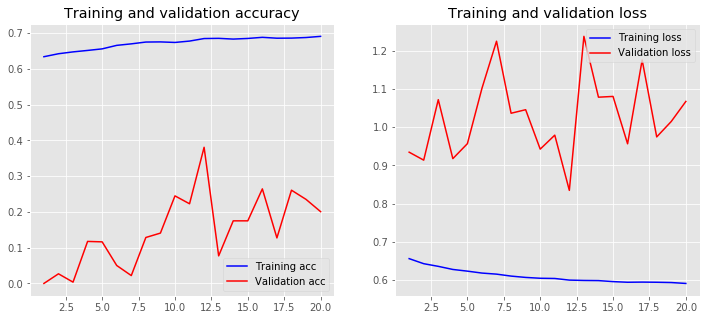

In [23]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)